In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time

C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Beyza\anaconda3\anacondaa3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [42]:
df = pd.read_csv('sample10.csv')  
data = pd.read_csv('sample10.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']  

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns) 
df = pd.concat([df, encoded_df], axis=1)  

columns_to_scale = df.columns

scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [43]:
latent_dim = 100
num_epochs = 20
batch_size = 64

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=latent_dim, output_dim=scaled_df.shape[1]).to(device)
discriminator = Discriminator(input_dim=scaled_df.shape[1]).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

data_tensor = torch.tensor(scaled_df.values, dtype=torch.float32).to(device)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)

def train_model():
    start_time = time.time()
    for epoch in range(num_epochs):
        for real_data in train_loader:
            real_data = real_data[0]

            batch_size = real_data.size(0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
    
    end_time = time.time()
    return end_time - start_time

if device.type == 'cuda':
    gpu_time = train_model()
    print(f"GPU eğitim süresi: {gpu_time:.2f} saniye")
else:
    cpu_time = train_model()
    print(f"CPU eğitim süresi: {cpu_time:.2f} saniye")

Epoch [1/20] | D Loss: 1.188559114933014 | G Loss: 0.7059221267700195
Epoch [2/20] | D Loss: 1.0637619197368622 | G Loss: 0.7196618914604187
Epoch [3/20] | D Loss: 0.8887363076210022 | G Loss: 0.8399909734725952
Epoch [4/20] | D Loss: 1.011429250240326 | G Loss: 0.8067446947097778
Epoch [5/20] | D Loss: 0.8779995441436768 | G Loss: 0.8596222996711731
Epoch [6/20] | D Loss: 0.9860847294330597 | G Loss: 0.9244503974914551
Epoch [7/20] | D Loss: 0.7777017056941986 | G Loss: 0.9845873117446899
Epoch [8/20] | D Loss: 0.8930957317352295 | G Loss: 0.9226598739624023
Epoch [9/20] | D Loss: 0.7758553326129913 | G Loss: 1.028990626335144
Epoch [10/20] | D Loss: 0.5945391654968262 | G Loss: 1.2166321277618408
Epoch [11/20] | D Loss: 0.6903387010097504 | G Loss: 1.181962013244629
Epoch [12/20] | D Loss: 0.817083090543747 | G Loss: 1.2110671997070312
Epoch [13/20] | D Loss: 0.8185688555240631 | G Loss: 1.061226487159729
Epoch [14/20] | D Loss: 0.9160678684711456 | G Loss: 1.1384072303771973
Epoch [

In [49]:
num_samples = 10000
noise = torch.randn(num_samples, latent_dim)

generated_data = generator(noise).detach().numpy()

generated_df = pd.DataFrame(generated_data, columns=scaled_df.columns)

generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])

categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_df.columns]))
categorical_output.columns = categorical_columns

generated_df = generated_df.drop(columns=encoded_df.columns)
generated_df = pd.concat([generated_df, categorical_output], axis=1)

generated_df['fraud_bool'].value_counts()

fraud_bool
-0.028312    2
-0.017670    2
-0.033818    2
-0.081036    1
-0.002409    1
            ..
-0.069617    1
-0.080508    1
-0.006197    1
 0.056438    1
-0.068805    1
Name: count, Length: 9997, dtype: int64

In [50]:
num_fraud_bool_over_0_1 = (generated_df['fraud_bool'] > 0.09).sum()
print(f"Fraud_bool > 0.1 olan satır sayısı: {num_fraud_bool_over_0_1}")
generated_df.loc[generated_df['fraud_bool'] > 0.09, 'fraud_bool'] = 0

Fraud_bool > 0.1 olan satır sayısı: 21


In [51]:
dtypes_dict = data.dtypes.to_dict()

for column, dtype in dtypes_dict.items():
    generated_df[column] = generated_df[column].astype(dtype)

In [52]:
generated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   name_email_similarity             10000 non-null  float64
 1   prev_address_months_count         10000 non-null  int64  
 2   current_address_months_count      10000 non-null  int64  
 3   days_since_request                10000 non-null  float64
 4   intended_balcon_amount            10000 non-null  float64
 5   zip_count_4w                      10000 non-null  int64  
 6   velocity_6h                       10000 non-null  float64
 7   velocity_24h                      10000 non-null  float64
 8   velocity_4w                       10000 non-null  float64
 9   bank_branch_count_8w              10000 non-null  int64  
 10  date_of_birth_distinct_emails_4w  10000 non-null  int64  
 11  credit_risk_score                 10000 non-null  int64  
 12  email

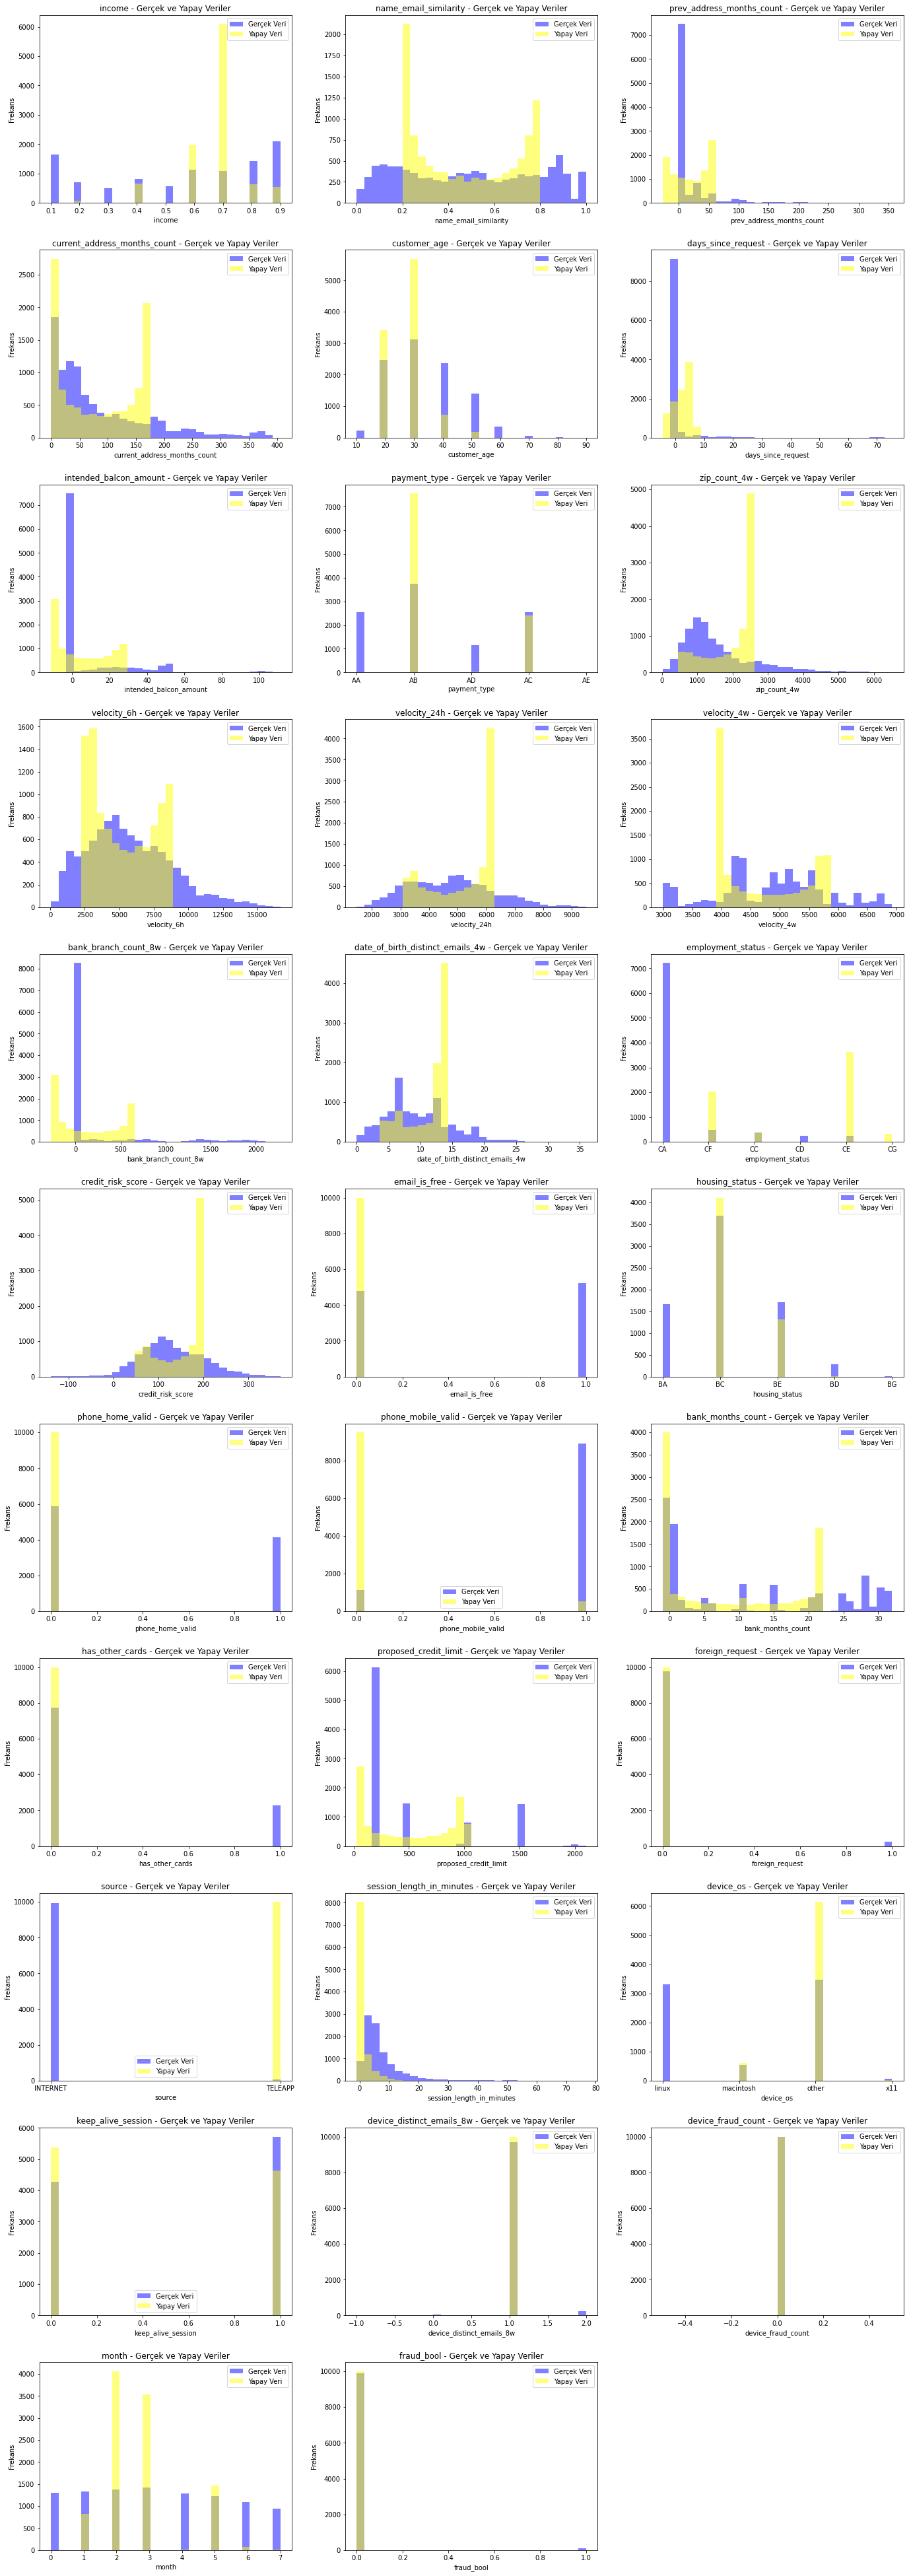

In [53]:
df = data

features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()